In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q nltk
!pip install -q tensorflow

In [ ]:
import pandas as pd
import re
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

In [ ]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/train.csv', header=None, names=['label', 'title', 'description'])
test = pd.read_csv('/content/drive/MyDrive/test.csv', header=None, names=['label', 'title', 'description'])


In [ ]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120001 entries, 0 to 120000
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        120001 non-null  object
 1   title        120001 non-null  object
 2   description  120001 non-null  object
dtypes: object(3)
memory usage: 2.7+ MB


,label,title,description
count,120001,120001,120001
unique,5,114351,118724
top,3,Today's schedule,"With the economy slowly turning up, upgrading ..."
freq,30000,39,15


In [ ]:
test.info()
test.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7601 entries, 0 to 7600
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        7601 non-null   object
 1   title        7601 non-null   object
 2   description  7601 non-null   object
dtypes: object(3)
memory usage: 178.3+ KB


,label,title,description
count,7601,7601,7601
unique,5,7569,7595
top,3,Today's schedule,"Sysco Corp., the country #39;s largest food se..."
freq,1900,4,2


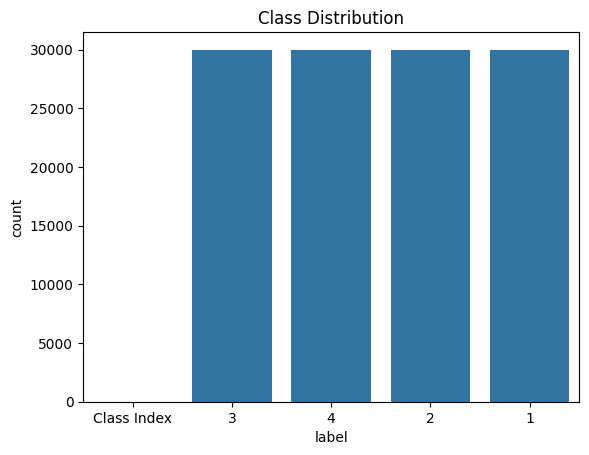

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='label', data=train)
plt.title("Class Distribution")
plt.show()


In [ ]:
for i in train['label'].unique():
    print(f"Class {i} sample titles:")
    print(train[train['label'] == i]['title'].head(3))
    print("\n")

Class Class Index sample titles:
0    Title
Name: title, dtype: object


Class 3 sample titles:
1    Wall St. Bears Claw Back Into the Black (Reuters)
2    Carlyle Looks Toward Commercial Aerospace (Reu...
3      Oil and Economy Cloud Stocks' Outlook (Reuters)
Name: title, dtype: object


Class 4 sample titles:
79    'Madden,' 'ESPN' Football Score in Different W...
80    Group to Propose New High-Speed Wireless Forma...
81    AOL to Sell Cheap PCs to Minorities and Senior...
Name: title, dtype: object


Class 2 sample titles:
449         Phelps, Thorpe Advance in 200 Freestyle (AP)
450         Reds Knock Padres Out of Wild-Card Lead (AP)
451    Dreaming done, NBA stars awaken to harsh Olymp...
Name: title, dtype: object


Class 1 sample titles:
493    Venezuelans Vote Early in Referendum on Chavez...
494    S.Koreans Clash with Police on Iraq Troop Disp...
495    Palestinians in Israeli Jails Start Hunger Str...
Name: title, dtype: object




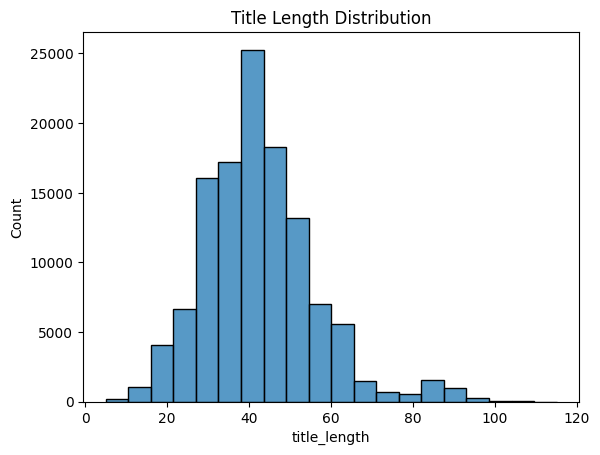

In [ ]:
train['title_length'] = train['title'].apply(len)
sns.histplot(train['title_length'], bins=20)
plt.title("Title Length Distribution")
plt.show()


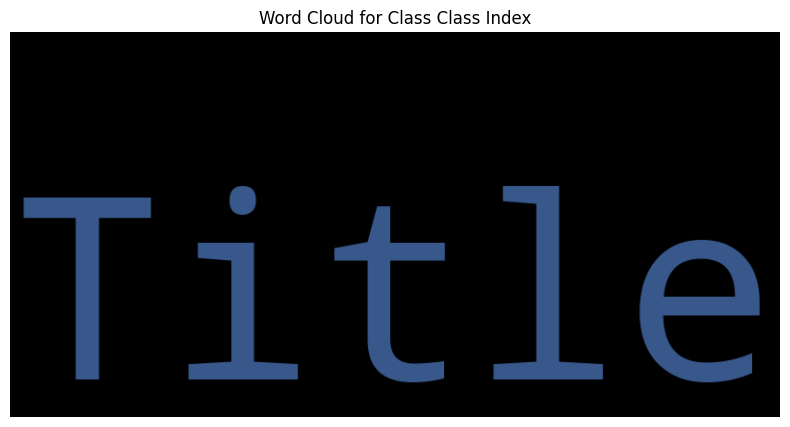

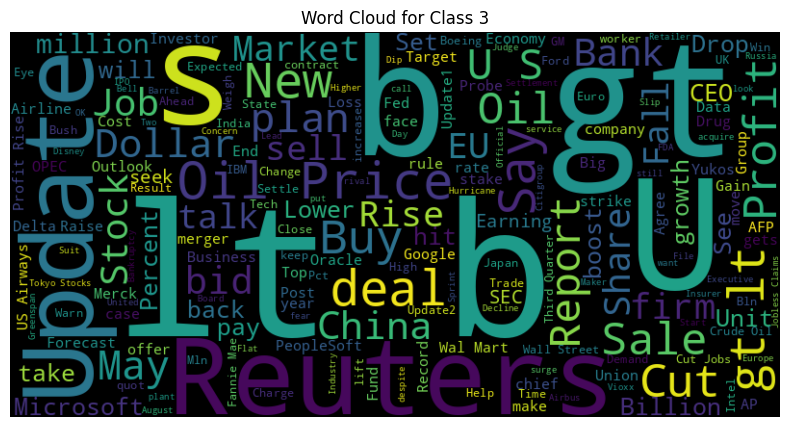

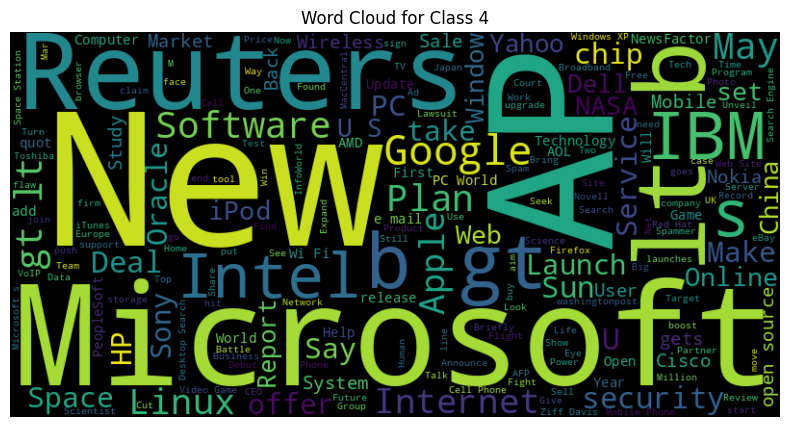

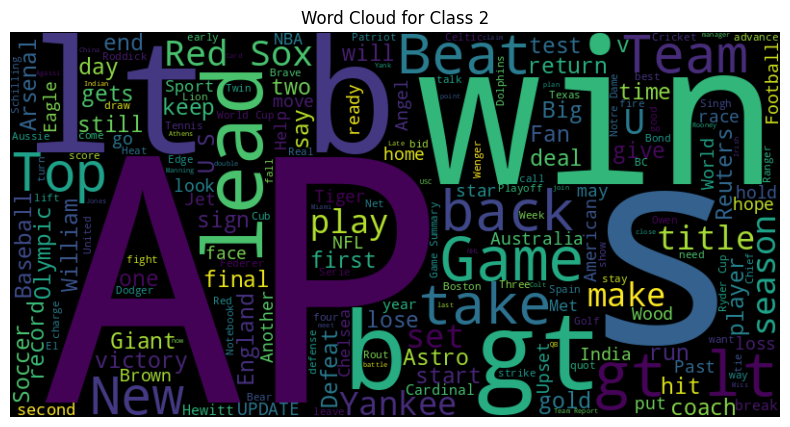

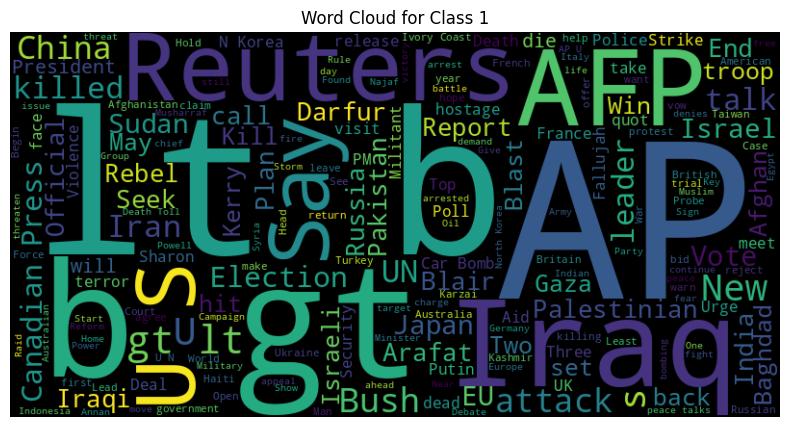

In [ ]:
from wordcloud import WordCloud

for i in train['label'].unique():
    text = " ".join(train[train['label']==i]['title'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Class {i}")
    plt.show()


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = [word for word in text.split() if word not in stop_words]
    return " ".join(words)

train['text'] = (train['title'] + " " + train['description']).apply(clean_text)
test['text'] = (test['title'] + " " + test['description']).apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_train = le.fit_transform(train['label'])
y_test = le.transform(test['label'])

num_classes = len(np.unique(y_train))

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)



In [ ]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
print(list(encoder.classes_))

[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [ ]:
label_map = {i: original for i, original in enumerate(encoder.classes_)}
print(label_map)


{0: np.int64(0), 1: np.int64(1), 2: np.int64(2), 3: np.int64(3), 4: np.int64(4)}


In [ ]:
import joblib
joblib.dump(le, "ml_label_encoder.pkl")

['ml_label_encoder.pkl']

In [ ]:
print("Unique labels after LabelEncoder:", np.unique(y_train))
print("Max label:", np.max(y_train))


Unique labels after LabelEncoder: [0 1 2 3 4]
Max label: 4


In [ ]:
def train_and_evaluate(model_name, model, vectorizer, X_train_text, X_test_text, y_train, y_test):
    X_train_vec = vectorizer.fit_transform(X_train_text)
    X_test_vec = vectorizer.transform(X_test_text)

    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{model_name} | {type(vectorizer).__name__}")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    return {
        "Model": model_name,
        "Vectorizer": type(vectorizer).__name__,
        "Accuracy": acc,
        "F1 Score": f1
    }


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(max_features=5000)
tfidf = TfidfVectorizer(max_features=5000)
vectorizers = [cv, tfidf]
best_model = None
best_vectorizer = None
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}
results = []
for name, model in models.items():
    for vect in vectorizers:
        result = train_and_evaluate(name, model, vect, train['text'], test['text'], y_train, y_test)
        results.append(result)

        if name == "Logistic Regression" and isinstance(vect, TfidfVectorizer):
            best_model = model
            best_vectorizer = vect


Logistic Regression | CountVectorizer
Accuracy: 0.8942244441520852
F1 Score: 0.8939639284753949
              precision    recall  f1-score   support

           1       0.91      0.89      0.90      1900
           2       0.94      0.97      0.95      1900
           3       0.86      0.86      0.86      1900
           4       0.86      0.87      0.86      1900
 Class Index       0.00      0.00      0.00         1

    accuracy                           0.89      7601
   macro avg       0.72      0.72      0.72      7601
weighted avg       0.89      0.89      0.89      7601



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression | TfidfVectorizer
Accuracy: 0.9036968819892119
F1 Score: 0.9033855956926488
              precision    recall  f1-score   support

           1       0.92      0.90      0.91      1900
           2       0.94      0.98      0.96      1900
           3       0.87      0.87      0.87      1900
           4       0.88      0.87      0.87      1900
 Class Index       0.00      0.00      0.00         1

    accuracy                           0.90      7601
   macro avg       0.72      0.72      0.72      7601
weighted avg       0.90      0.90      0.90      7601



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Naive Bayes | CountVectorizer
Accuracy: 0.8886988554137614
F1 Score: 0.8882125810809445
              precision    recall  f1-score   support

           1       0.90      0.89      0.89      1900
           2       0.94      0.97      0.95      1900
           3       0.86      0.83      0.85      1900
           4       0.85      0.86      0.86      1900
 Class Index       0.00      0.00      0.00         1

    accuracy                           0.89      7601
   macro avg       0.71      0.71      0.71      7601
weighted avg       0.89      0.89      0.89      7601



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Naive Bayes | TfidfVectorizer
Accuracy: 0.8894882252335219
F1 Score: 0.8890652423834698
              precision    recall  f1-score   support

           1       0.90      0.89      0.89      1900
           2       0.94      0.97      0.95      1900
           3       0.86      0.84      0.85      1900
           4       0.86      0.86      0.86      1900
 Class Index       0.00      0.00      0.00         1

    accuracy                           0.89      7601
   macro avg       0.71      0.71      0.71      7601
weighted avg       0.89      0.89      0.89      7601



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest | CountVectorizer
Accuracy: 0.8869885541376135
F1 Score: 0.8865703943565504
              precision    recall  f1-score   support

           1       0.91      0.89      0.90      1900
           2       0.91      0.96      0.94      1900
           3       0.86      0.85      0.85      1900
           4       0.86      0.85      0.86      1900
 Class Index       1.00      1.00      1.00         1

    accuracy                           0.89      7601
   macro avg       0.91      0.91      0.91      7601
weighted avg       0.89      0.89      0.89      7601

Random Forest | TfidfVectorizer
Accuracy: 0.8856729377713459
F1 Score: 0.8851589032626327
              precision    recall  f1-score   support

           1       0.90      0.88      0.89      1900
           2       0.91      0.97      0.94      1900
           3       0.86      0.84      0.85      1900
           4       0.86      0.85      0.86      1900
 Class Index       1.00      1.00      1.00         1

    a

In [ ]:
results_df = pd.DataFrame(results)
print("\n Final Comparison Table:")
print(results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True))


 Final Comparison Table:
                 Model       Vectorizer  Accuracy  F1 Score
0  Logistic Regression  TfidfVectorizer  0.903697  0.903386
1  Logistic Regression  CountVectorizer  0.894224  0.893964
2          Naive Bayes  TfidfVectorizer  0.889488  0.889065
3          Naive Bayes  CountVectorizer  0.888699  0.888213
4        Random Forest  CountVectorizer  0.886989  0.886570
5        Random Forest  TfidfVectorizer  0.885673  0.885159


In [ ]:
import joblib

joblib.dump(best_model, 'logistic_regression_model.pkl')
joblib.dump(best_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [ ]:
import joblib
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
joblib.dump(le, "dl_label_encoder.pkl")

['dl_label_encoder.pkl']

In [ ]:
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train['text'])

# Vectorizer 1: Regular padded sequence
X_train_pad1 = pad_sequences(tokenizer.texts_to_sequences(train['text']), maxlen=100, padding='post')
X_test_pad1 = pad_sequences(tokenizer.texts_to_sequences(test['text']), maxlen=100, padding='post')

# Vectorizer 2: Truncated shorter sequence
X_train_pad2 = pad_sequences(tokenizer.texts_to_sequences(train['text']), maxlen=50, padding='post')
X_test_pad2 = pad_sequences(tokenizer.texts_to_sequences(test['text']), maxlen=50, padding='post')


In [ ]:
def train_dl_model(name, model_fn, X_train, X_test, y_train_cat, y_test_cat, y_test, max_len):
    model = model_fn(vocab_size, max_len)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train_cat, epochs=5, batch_size=128, validation_split=0.1, verbose=1)

    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n {name} Results")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    return {
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1
    }, model


In [ ]:
def create_lstm_model(vocab_size, max_len):
    model = Sequential([
        Embedding(vocab_size, 64, input_length=max_len),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_gru_model(vocab_size, max_len):
    model = Sequential([
        Embedding(vocab_size, 64, input_length=max_len),
        GRU(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
dl_results = []

# LSTM with full padding
dl_results.append(train_dl_model("LSTM + Pad(100)", create_lstm_model, X_train_pad1, X_test_pad1, y_train_cat, y_test_cat, y_test, 100))

# LSTM with shorter padding
dl_results.append(train_dl_model("LSTM + Pad(50)", create_lstm_model, X_train_pad2, X_test_pad2, y_train_cat, y_test_cat, y_test, 50))

# GRU with full padding
dl_results.append(train_dl_model("GRU + Pad(100)", create_gru_model, X_train_pad1, X_test_pad1, y_train_cat, y_test_cat, y_test, 100))

# GRU with shorter padding
dl_results.append(train_dl_model("GRU + Pad(50)", create_gru_model, X_train_pad2, X_test_pad2, y_train_cat, y_test_cat, y_test, 50))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.2503 - loss: 1.4127 - val_accuracy: 0.2656 - val_loss: 1.3867
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2498 - loss: 1.3883 - val_accuracy: 0.2656 - val_loss: 1.3858
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2538 - loss: 1.3877 - val_accuracy: 0.2381 - val_loss: 1.3868
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.2522 - loss: 1.3871 - val_accuracy: 0.2442 - val_loss: 1.3887
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2509 - loss: 1.3872 - val_accuracy: 0.2521 - val_loss: 1.3877
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

 LSTM + Pad(100) Results
Accuracy: 0.2499671095908433
F1 Score: 0.09997632001317805
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1900
           2       0.25      1.00      0.40      1900
           3       0.00      0.00      0.00      1900
           4      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3402 - loss: 1.2851 - val_accuracy: 0.5409 - val_loss: 1.0187
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6555 - loss: 0.8190 - val_accuracy: 0.8809 - val_loss: 0.3497
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9007 - loss: 0.3165 - val_accuracy: 0.8967 - val_loss: 0.3054
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9265 - loss: 0.2422 - val_accuracy: 0.8877 - val_loss: 0.3200
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9380 - loss: 0.2041 - val_accuracy: 0.9036 - val_loss: 0.2834
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

 LSTM + Pad(50) Results
Accuracy: 0.9092224707275358
F1 Score: 0.9090191013459699
              precision    recall  f1-score   support

           1       0.93      0.90      0.91      1900
           2       0.95      0.97      0.96      1900
           3       0.88      0.87      0.88      1900
           4       0.87      0.9

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2497 - loss: 1.4071 - val_accuracy: 0.2521 - val_loss: 1.3869
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.2493 - loss: 1.3882 - val_accuracy: 0.2521 - val_loss: 1.3862
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2503 - loss: 1.3875 - val_accuracy: 0.2521 - val_loss: 1.3859
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2468 - loss: 1.3875 - val_accuracy: 0.2521 - val_loss: 1.3875
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.2474 - loss: 1.3877 - val_accuracy: 0.2442 - val_loss: 1.3888
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

 GRU + Pad(100) Results
Accuracy: 0.2499671095908433
F1 Score: 0.09997632001317805
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1900
           2       0.00      0.00      0.00      1900
           3       0.00      0.00      0.00      1900
           4       0.25      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4476 - loss: 1.1069 - val_accuracy: 0.9043 - val_loss: 0.2814
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9237 - loss: 0.2444 - val_accuracy: 0.9037 - val_loss: 0.2669
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9384 - loss: 0.1948 - val_accuracy: 0.9119 - val_loss: 0.2649
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9488 - loss: 0.1579 - val_accuracy: 0.9052 - val_loss: 0.2825
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9549 - loss: 0.1378 - val_accuracy: 0.9004 - val_loss: 0.3235
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

 GRU + Pad(50) Results
Accuracy: 0.9079068543612683
F1 Score: 0.9077562710849237
              precision    recall  f1-score   support

           1       0.93      0.89      0.91      1900
           2       0.95      0.97      0.96      1900
           3       0.88      0.86      0.87      1900
           4       0.87      0.90

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
metrics_only = [item[0] if isinstance(item, tuple) else item for item in dl_results]

# Create DataFrame from just the metrics
dl_df = pd.DataFrame(metrics_only)

print("\nDeep Learning Model Comparison:")
print(dl_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True))


Deep Learning Model Comparison:
             Model  Accuracy  F1 Score
0   LSTM + Pad(50)  0.909222  0.909019
1    GRU + Pad(50)  0.907907  0.907756
2  LSTM + Pad(100)  0.249967  0.099976
3   GRU + Pad(100)  0.249967  0.099976


In [ ]:
gru_pad50_result, gru_pad50_model = train_dl_model(
    "GRU + Pad(50)",
    create_gru_model,
    X_train_pad1,
    X_test_pad1,
    y_train_cat,
    y_test_cat,
    y_test,
    50
)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.2482 - loss: 1.4124 - val_accuracy: 0.2521 - val_loss: 1.3866
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2520 - loss: 1.3885 - val_accuracy: 0.2442 - val_loss: 1.3869
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2486 - loss: 1.3876 - val_accuracy: 0.2656 - val_loss: 1.3863
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.2487 - loss: 1.3874 - val_accuracy: 0.2521 - val_loss: 1.3873
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3338 - loss: 1.2578 - val_accuracy: 0.8700 - val_loss: 0.3914
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

 GRU + Pad(50) Results
Accuracy: 0.874095513748191
F1 Score: 0.8730692405112409
              precision    recall  f1-score   support

           1       0.87      0.88      0.87      1900
           2       0.94      0.97      0.96      1900
           3       0.86      0.77      0.81      1900
           4       0.82      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from google.colab import files
import joblib

# Save the GRU model
gru_pad50_model.save("gru_pad50_model.h5")

# Save the tokenizer
joblib.dump(tokenizer, "gru_pad50_tokenizer.pkl")

# Download both if you're on Colab
from google.colab import files
files.download("gru_pad50_model.h5")
files.download("gru_pad50_tokenizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip uninstall -y transformers

Found existing installation: transformers 4.55.0
Uninstalling transformers-4.55.0:
  Successfully uninstalled transformers-4.55.0


In [ ]:
!pip install transformers==4.44.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 106.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokenizers-0.21.4:
      Successfully uninstalled tokenizers-0.21.4


In [ ]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/train.csv', header=None, names=['label', 'title', 'description'])
test = pd.read_csv('/content/drive/MyDrive/test.csv', header=None, names=['label', 'title', 'description'])


In [ ]:
print(train.columns)

Index(['label', 'title', 'description'], dtype='object')


In [ ]:
train['text'] = train['title'].astype(str) + " " + train['description'].astype(str)
test['text'] = test['title'].astype(str) + " " + test['description'].astype(str)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create label encoder
label_encoder = LabelEncoder()

# Fit on training labels and transform both train and test
train['label'] = label_encoder.fit_transform(train['label'])
test['label'] = label_encoder.transform(test['label'])

# Now recreate Hugging Face datasets
from datasets import Dataset
train_ds = Dataset.from_pandas(train[['text', 'label']])
test_ds = Dataset.from_pandas(test[['text', 'label']])


In [ ]:
joblib.dump(label_encoder, "transformer_label_encoder.pkl")

['transformer_label_encoder.pkl']

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer_max = AutoTokenizer.from_pretrained(checkpoint)
tokenizer_long = AutoTokenizer.from_pretrained(checkpoint)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Tokenizer 1: max_length
def tokenize_max(examples):
    return tokenizer_max(examples['text'], padding="max_length", truncation=True)

# Tokenizer 2: longest
def tokenize_longest(examples):
    return tokenizer_long(examples['text'], padding="longest", truncation=True)

# Apply both
train_max = train_ds.map(tokenize_max, batched=True)
test_max = test_ds.map(tokenize_max, batched=True)

train_long = train_ds.map(tokenize_longest, batched=True)
test_long = test_ds.map(tokenize_longest, batched=True)


Map:   0%|          | 0/120001 [00:00<?, ? examples/s]

Map:   0%|          | 0/7601 [00:00<?, ? examples/s]

Map:   0%|          | 0/120001 [00:00<?, ? examples/s]

Map:   0%|          | 0/7601 [00:00<?, ? examples/s]

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

# Patch torch.load so HF ignores weights_only=True
orig_torch_load = torch.load
def torch_load_with_full_unpickling(*args, **kwargs):
    kwargs["weights_only"] = False
    return orig_torch_load(*args, **kwargs)
torch.load = torch_load_with_full_unpickling


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import os
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted')
    }

def train_transformer_model(model_name, tokenized_train, tokenized_test, tokenizer, output_dir, save_steps=500):
    # Check for checkpoint
    last_checkpoint = None
    if os.path.isdir(output_dir):
        checkpoints = [os.path.join(output_dir, d) for d in os.listdir(output_dir) if d.startswith("checkpoint")]
        if checkpoints:
            last_checkpoint = max(checkpoints, key=os.path.getctime)
            print(f"Resuming from checkpoint: {last_checkpoint}")

    # Load model
    torch.serialization.add_safe_globals([AutoModelForSequenceClassification])

    if last_checkpoint:
      model = AutoModelForSequenceClassification.from_pretrained(
          last_checkpoint,
          trust_remote_code=True
    )
    else:
      model = AutoModelForSequenceClassification.from_pretrained(
          model_name,
          num_labels=num_labels
    )

    # Training args — saving every n steps
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="steps",   # evaluate during steps
        eval_steps=save_steps,         # evaluate every save_steps
        save_strategy="steps",         # save during steps
        save_steps=save_steps,         # save every n steps
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        weight_decay=0.01,
        save_total_limit=3,            # keep only last 3 checkpoints
        logging_dir=f"{output_dir}/logs",
        logging_steps=100,             # log every 100 steps
        push_to_hub=False,
        resume_from_checkpoint=last_checkpoint if last_checkpoint else None
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )

    # Train
    trainer.train(resume_from_checkpoint=last_checkpoint if last_checkpoint else None)

    # Save final
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    return model


In [ ]:
num_classes = len(np.unique(train['label']))

# DistilBERT with max_length
distilbert_max_model = train_transformer_model(
    "distilbert-base-uncased",
    train_max,
    test_max,
    tokenizer_max,
    "/content/drive/MyDrive/distilbert_max",
    save_steps=500
)

Resuming from checkpoint: /content/drive/MyDrive/distilbert_max/checkpoint-5000


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1
5500,0.201800,0.192902,0.937640,0.937820
6000,0.203700,0.187085,0.938692,0.938668
6500,0.172100,0.185682,0.941455,0.941462
7000,0.153500,0.185205,0.942639,0.942602
7500,0.179700,0.184170,0.941587,0.941505


In [ ]:
num_classes = len(np.unique(train['label']))

distilbert_long_model = train_transformer_model(
    "distilbert-base-uncased",
    train_long,
    test_long,
    tokenizer_long,
    "/content/drive/MyDrive/distilbert_long",
    save_steps=500
)

In [ ]:
trainer.train(resume_from_checkpoint=True)

In [ ]:
import pandas as pd
import joblib

# Load your training dataset
df = pd.read_csv("/content/drive/MyDrive/train.csv")  # replace with your actual dataset

# Build mapping from class_index to title
label_map_fin = dict(zip(df["Class Index"], df["Title"]))

# Save it
joblib.dump(label_map_fin, "label_map_fin.pkl")
print("Saved label_map with", len(label_map_fin), "classes")


Saved label_map with 4 classes


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

# Load your training dataset
train = pd.read_csv('/content/drive/MyDrive/train.csv', header=None, names=['label', 'title', 'description'])
test = pd.read_csv('/content/drive/MyDrive/test.csv', header=None, names=['label', 'title', 'description'])

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = [word for word in text.split() if word not in stop_words]
    return " ".join(words)

train['text'] = (train['title'] + " " + train['description']).apply(clean_text)
test['text'] = (test['title'] + " " + test['description']).apply(clean_text)


# Create & fit encoder
le = LabelEncoder()
le.fit(train["label"].values)

# Save encoder
joblib.dump(le, "label_encoder_final.pkl")
print("Classes mapping:", le.classes_)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Classes mapping: ['1' '2' '3' '4' 'Class Index']


In [ ]:
import joblib
from tensorflow.keras.models import load_model

# Load tokenizer (joblib pickle)
tokenizer = joblib.load("/content/drive/MyDrive/gru_pad50_tokenizer.pkl")

# Load DL model (keras h5)
model = load_model("/content/drive/MyDrive/gru_pad50_model.h5")

# Load label encoder (joblib pickle)
label_encoder = joblib.load("/content/drive/MyDrive/dl_label_encoder.pkl")

# Example input
test_text = ["India won the cricket match after scoring high runs"]

# Tokenize & pad (same way you did during training)
from tensorflow.keras.preprocessing.sequence import pad_sequences

seqs = tokenizer.texts_to_sequences(test_text)
X_new = pad_sequences(seqs, maxlen=50, padding="post")

# Predict
pred = model.predict(X_new)
pred_class = pred.argmax(axis=1)
pred_label = label_encoder.inverse_transform(pred_class)[0]

print("Prediction:", pred_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: 2


In [ ]:
label_encoder = joblib.load("/content/drive/MyDrive/dl_label_encoder.pkl")

pred_class = pred.argmax(axis=1)
pred_label = label_encoder.inverse_transform(pred_class)[0]

print("Prediction:", pred_label)


Prediction: 2
